<H1> Using PlanetOS API to produce weather forecast graphs </H1>

Introduction to practical use of PlanetOS API data format.
For information about Jupyter notebook, please see https://jupyter.readthedocs.org/en/latest/index.html

Note: use python3 or change urllib commands, for python2.

<H2> GFS global weather forecast model </H2>
GFS is a well known and widely used weather forecast model, developed and used operationally by NCEP (http://www.emc.ncep.noaa.gov/). This model outputs 15 day global weather forecast on 12 degree grid.


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import dateutil.parser
import datetime
from urllib.request import urlopen, Request
import simplejson as json

Initialize point coordinates _longitude_, _latitude_ and make short query (count=10), to save time. Please remember to include correct API key!

In [2]:
longitude = 24.+36./60
latitude = 59+24./60
apikey = 'd7d0466b16e24b7084d0c97ea8343762'

In [3]:
#API_url = "http://data.planetos.com/api/data/dataset_physical_values/noaa_gfs_global_sflux_0.12d?lon={0}&lat={1}&count=10&verbose=true".format(longitude,latitude)
API_url = "http://api.planetos.com/v1/datasets/noaa_gfs_global_sflux_0.12d/point?lon={0}&lat={1}&count=10&verbose=true&apikey={2}".format(longitude,latitude,apikey)
print(API_url)
request = Request(API_url)
response = urlopen(request)
API_data = json.loads(response.read())

http://api.planetos.com/v1/datasets/noaa_gfs_global_sflux_0.12d/point?lon=24.6&lat=59.4&count=10&verbose=true&apikey=d7d0466b16e24b7084d0c97ea8343762


Investigate, what we received. 



API response is divided into _entries_, _stats_ and _metadata_, where _stats_ gives info about available data extent, _metadata_ for gives full information about variables, and _entries_ has actual data. 
Data in the _entries_ section is divided into different messages, where each has desctiption for _axes_, which describes time and location of data, _context_, which describes the coordinate types, and _data_, which gives the actual variables with corresponding values. 

To efficiently use the data, we loop through messages and collect data to separate variables.

But first, let's try filtering data by variable type (precipitation, temperature, etc, ...). For this, list all related variables and their context. Note that not all variables are available for all timesteps!

In [4]:
print("{0:<50} {1}".format("Variable","Context"))
print()
for k,v in set([(j,i['context']) for i in API_data['entries'] for j in i['data'].keys() if 'wind' in j.lower()]):
    print("{0:<50} {1}".format(k,v))

Variable                                           Context

u-component_of_wind_height_above_ground            reftime_time_height_above_ground1_lat_lon
v-component_of_wind_hybrid                         reftime_time_hybrid_lat_lon
v-component_of_wind_height_above_ground            reftime_time_height_above_ground1_lat_lon
u-component_of_wind_hybrid                         reftime_time_hybrid_lat_lon


Select data for time and data axes. As we do not necessariy now beforehand, what data is available at what timestep, make separate time variable for each data variable. For easier plotting/analysis, convert time string to datetime.

In [5]:
time_axes = []
time_axes_precipitation = []
time_axes_wind = []
surface_temperature = []
air2m_temperature = []
precipitation_rate = []
wind_speed = []
for i in API_data['entries']:
    #print(i['axes']['time'])
    if i['context'] == 'reftime_time_lat_lon':
        surface_temperature.append(i['data']['Temperature_surface'])
        time_axes.append(dateutil.parser.parse(i['axes']['time']))
    if i['context'] == 'reftime_time1_lat_lon':
        if 'Precipitation_rate_surface_3_Hour_Average' in i['data']:
            precipitation_rate.append(i['data']['Precipitation_rate_surface_3_Hour_Average']*3*3600)
            time_axes_precipitation.append(dateutil.parser.parse(i['axes']['time']))
    if i['context'] == 'reftime_time_height_above_ground_lat_lon':
        air2m_temperature.append(i['data']['Temperature_height_above_ground'])
    if i['context'] == 'reftime_time_height_above_ground1_lat_lon':
        wind_speed.append(np.sqrt(i['data']['u-component_of_wind_height_above_ground']**2+i['data']['v-component_of_wind_height_above_ground']**2))
        time_axes_wind.append(dateutil.parser.parse(i['axes']['time']))

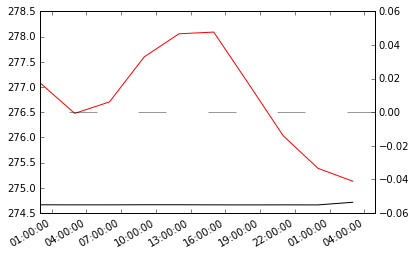

In [6]:
time_axes_precipitation = np.array(time_axes_precipitation)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(time_axes,surface_temperature,color='k',label='Surface temperature')
ax.plot(time_axes,air2m_temperature,color='r',label='2m temperature')
ax_r = ax.twinx()
ax_r.bar(time_axes_precipitation-datetime.timedelta(seconds=1800),precipitation_rate,width=0.1,alpha=0.4)
fig.autofmt_xdate()
plt.show()

We could improve this plot by extending the time axes. We can do this by increasing _count_ in API call, we may also note that only three contexts are needed for the data we use, and by skipping others we may save some time.

We must be careful with reference times, because in some cases two reference times may be available!

In [7]:
API_url = "http://api.planetos.com/v1/datasets/noaa_gfs_global_sflux_0.12d/point?lon={0}&lat={1}&count=1000&verbose=true&apikey={2}&contexts=reftime_time_lat_lon,reftime_time1_lat_lon,reftime_time_height_above_ground_lat_lon".format(longitude,latitude,apikey)
request2 = Request(API_url)
response2 = urlopen(request2)
API_data2 = json.loads(response2.read())

Find available reference times

In [8]:
reftimes = set()
for i in API_data2['entries']:
    reftimes.update([i['axes']['reftime']])
reftimes=list(reftimes)

In [9]:
reftimes

['2016-04-11T00:00:00', '2016-04-11T06:00:00']

Use only smaller reftime in example, but newer reftime may give more recent forecast!

In [10]:
if len(reftimes)>1:
    reftime = reftimes[1] if dateutil.parser.parse(reftimes[0])<dateutil.parser.parse(reftimes[1]) else reftimes[1]
else:
    reftime = reftimes[0]

Create new plot with longer time scale and one more variable

In [11]:
time_2mt = []
time_surft = []
time_precipitation = []
time_surfrad = []
surface_temperature = []
air2m_temperature = []
precipitation_rate = []
surfrad = []
for i in API_data2['entries']:
    #print(i['context'])
    if i['context'] == 'reftime_time_lat_lon' and i['axes']['reftime']==reftime:
        surface_temperature.append(i['data']['Temperature_surface']-273.15)
        time_surft.append(dateutil.parser.parse(i['axes']['time']))
    if i['context'] == 'reftime_time1_lat_lon' and i['axes']['reftime']==reftime:
        if 'Precipitation_rate_surface_3_Hour_Average' in i['data']:
            precipitation_rate.append(i['data']['Precipitation_rate_surface_3_Hour_Average']*3*3600)
            time_precipitation.append(dateutil.parser.parse(i['axes']['time']))
        if 'Downward_Short-Wave_Radiation_Flux_surface_3_Hour_Average' in i['data']:
            surfrad.append(i['data']['Downward_Short-Wave_Radiation_Flux_surface_3_Hour_Average'])
            time_surfrad.append(dateutil.parser.parse(i['axes']['time']))
    if i['context'] == 'reftime_time_height_above_ground_lat_lon' and i['axes']['reftime']==reftime:
        if 'Temperature_height_above_ground' in i['data']:
            air2m_temperature.append(i['data']['Temperature_height_above_ground']-273.15)
            time_2mt.append(dateutil.parser.parse(i['axes']['time']))

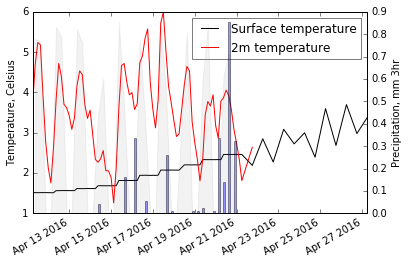

In [12]:
time_precipitation = np.array(time_precipitation)
surfrad=np.array(surfrad)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(time_surft,surface_temperature,color='k',label='Surface temperature')
plt.plot(time_2mt,air2m_temperature,color='r',label='2m temperature')
lg = plt.legend(framealpha=0.2)
ax.set_ylabel('Temperature, Celsius')

ax_r = ax.twinx()
ax_r.bar(time_precipitation-datetime.timedelta(seconds=1800),precipitation_rate,width=0.1,alpha=0.4,label='precipitation')
ax_r.fill_between(time_surfrad,surfrad/np.amax(surfrad)*np.amax(precipitation_rate),color='gray',alpha=0.1,label='surface radiation')
ax_r.set_ylabel('Precipitation, mm 3hr')
lg.get_frame().set_alpha(0.5)

fig.autofmt_xdate()

In [29]:
plt.show()

In [13]:
time_precipitation

array([datetime.datetime(2016, 4, 11, 9, 0),
       datetime.datetime(2016, 4, 11, 15, 0),
       datetime.datetime(2016, 4, 11, 21, 0),
       datetime.datetime(2016, 4, 12, 3, 0),
       datetime.datetime(2016, 4, 12, 9, 0),
       datetime.datetime(2016, 4, 12, 15, 0),
       datetime.datetime(2016, 4, 12, 21, 0),
       datetime.datetime(2016, 4, 13, 3, 0),
       datetime.datetime(2016, 4, 13, 9, 0),
       datetime.datetime(2016, 4, 13, 15, 0),
       datetime.datetime(2016, 4, 13, 21, 0),
       datetime.datetime(2016, 4, 14, 3, 0),
       datetime.datetime(2016, 4, 14, 9, 0),
       datetime.datetime(2016, 4, 14, 15, 0),
       datetime.datetime(2016, 4, 14, 21, 0),
       datetime.datetime(2016, 4, 15, 3, 0),
       datetime.datetime(2016, 4, 15, 9, 0),
       datetime.datetime(2016, 4, 15, 15, 0),
       datetime.datetime(2016, 4, 15, 21, 0),
       datetime.datetime(2016, 4, 16, 3, 0),
       datetime.datetime(2016, 4, 16, 9, 0),
       datetime.datetime(2016, 4, 16, 15, 0),